# A Monte Carlo for semiparametric efficiency causal ML

Jiafeng Chen, [jiafengchen@g.harvard.edu](mailto:jiafengchen@g.harvard.edu)

[Open in Google Colab](https://colab.research.google.com/github/jiafengkevinchen/semiparametrics-tutorial/blob/master/experiment.ipynb)

##  A more or less standard experiment to illustrate finite sample performance of various ATE estimators
$X$ is scalar, but continuous, so nonparametrics is nontrivial. The nonparametrics is handled via high order polynomials

In [320]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set_style("white")
sns.set_color_codes()
sns.set_palette("Set1")
mpl.rcParams["figure.dpi"] = 100 

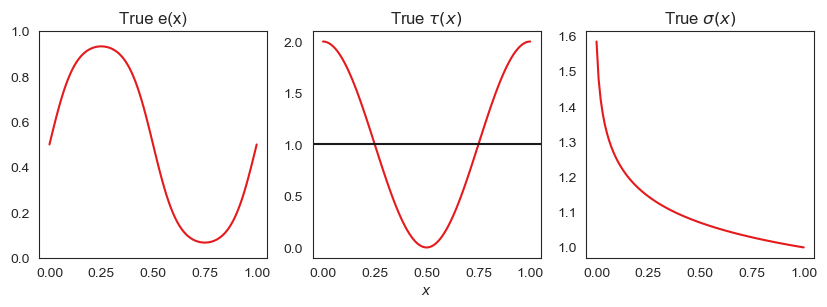

In [419]:
# Define primitives of the DGP
propensity_score = lambda x : norm.cdf(1.5 * np.sin(2 * np.pi * x))
cond_sd_y = lambda x: ((1 / (0.01 + x)) ** 0.1)[:, None]
cond_mean_y = lambda x: np.exp(x)[:, None]
te_x_diff = lambda x: np.cos(2 * np.pi * x)


# Illustrate true primitives of the model
xs = np.linspace(0, 1, 100)

f, axs = plt.subplots(figsize=(10,3), ncols=3,sharex=True)
axs[0].plot(xs, propensity_score(xs))
axs[0].set_title("True e(x)")
axs[0].set_ylim((0,1))

axs[1].plot(xs, 1 + te_x_diff(xs))
axs[1].set_title("True $\\tau(x)$")
axs[1].axhline(1, color="k")
axs[1].set_xlabel("$x$")

plt.plot(xs, cond_sd_y(xs))
plt.title("True $\\sigma(x)$")
plt.savefig("design_simple.eps", transparent=True)

In [128]:
def data(n):
    """Data-generating process"""
    x = np.random.rand(n)
    w = (np.random.rand(n) < propensity_score(x)).astype(int)
    po = np.random.randn(n, 2) * cond_sd_y(x) + cond_mean_y(x)
    po[:, 1] += 1 + np.cos(2 * np.pi * x)  # ATE = 1, but heterogeneous TE
    y = po[list(range(n)), w]
    return po, y, x, w

In [129]:
def simulate(n):
    """
    Calculate various estimators
    - IPW (plug-in estimate vs. plug-in true propensity score)
    - AIPW / Doubly robust / efficient score
    - Hahn (1998)'s estimator
    - Outcome modeling / imputation
    - Saturated polynomial regression (equivalent to outcome modeling, 
      but can calculate EHW standard errors, which *may* be correct)
    - OLS, pretending everything is linear
    - Naive difference in mean without adjusting for X
    """
    # Get data
    po, y, x, w = data(n)

    # Naive 
    naive_ate = (y * w).sum() / w.sum() - (y * (1 - w)).sum() / (1 - w).sum()
    
    # OLS
    design = add_constant(np.c_[w, x - x.mean(), w * (x - x.mean())])
    ols_ate = (np.linalg.inv(design.T @ design) @ design.T @ (y - y.mean()))[1]
    true_ipw_ate = (
        y * w / propensity_score(x) - y * (1 - w) / (1 - propensity_score(x))
    ).mean()

    # Make the basis function matrix for polynomial regression
    # Surely degree = 4 polynomials are nonparametric; But srsly this only makes sense if degree -> \infty
    series_design = add_constant(np.c_[x, x ** 2, x ** 3, x ** 4])
    demeaned_series = (
        series_design[:, 1:] - series_design[:, 1:].mean(0, keepdims=True)
    ).copy()
    series_design_w = add_constant(
        np.c_[demeaned_series, w, w[:, None] * demeaned_series]
    )
    
    # Fit a polynomial regression, the demeaning allows for reading off the parameter
    mod = sm.OLS(endog=y - y.mean(), exog=series_design_w, hasconst=True)
    fit = mod.fit(cov_type="HC1")
    poly_ate, poly_se = fit.params[5], fit.bse[5]

    # Outcome modeling / imputation, which is equivalent to poly_ate
    om_treated_coef = (
        np.linalg.inv(series_design[w == 1].T @ series_design[w == 1])
        @ series_design[w == 1].T
        @ y[w == 1]
    )
    om_control_coef = (
        np.linalg.inv(series_design[w == 0].T @ series_design[w == 0])
        @ series_design[w == 0].T
        @ y[w == 0]
    )
    mu1 = series_design @ om_treated_coef
    mu0 = series_design @ om_control_coef
    om_ate = (mu1 - mu0).mean()
    om_se = (mu1 - mu0).std() / n ** 0.5 # This SE is naive and wrong

    # Estimate propensity score with series
    # Linear probability model winsorizing at 0.05, 0.95, sue me
    estimated_prop_score = np.clip(
        series_design
        @ (np.linalg.inv(series_design.T @ series_design) @ series_design.T @ w),
        a_min=0.05,
        a_max=0.95,
    )

    # IPW with plug-in estimate of pscore
    estimated_ipw_array = y * w / estimated_prop_score - y * (1 - w) / (
        1 - estimated_prop_score
    )
    estimated_ipw_ate = estimated_ipw_array.mean()
    estimated_ipw_se = estimated_ipw_array.std() / n ** 0.5

    # AIPW
    dr_array = (
        (y - mu1) * w / estimated_prop_score
        - (y - mu0) * (1 - w) / (1 - estimated_prop_score)
        + mu1
        - mu0
    )
    dr_ate = dr_array.mean()
    dr_se = dr_array.std() / n ** 0.5 # this SE is right

    # Hahn's estimator
    g1 = series_design @ (
        np.linalg.inv(series_design.T @ series_design) @ series_design.T @ (y * w)
    )
    g0 = series_design @ (
        np.linalg.inv(series_design.T @ series_design) @ series_design.T @ (y * (1 - w))
    )
    hahn_ate = (g1 / estimated_prop_score - g0 / (1 - estimated_prop_score)).mean()

    # Assemble and return the result as a dict
    result = {
        "naive": naive_ate,
        "ols": ols_ate,
        "true_ipw": true_ipw_ate,
        "outcome_modeling": om_ate,
        "outcome_modeling_se": om_se,
        "estimated_ipw": estimated_ipw_ate,
        "estimated_ipw_se": estimated_ipw_se,
        "doubly_robust": dr_ate,
        "doubly_robust_se": dr_se,
        "hahn": hahn_ate,
        "poly": poly_ate,
        "poly_se": poly_se,
    }
    return result

In [367]:
n = 1000
ns = 6000
result = pd.DataFrame([simulate(n) for _ in tqdm(range(ns))])

In [368]:
# An awkward Monte Carlo approximation to the efficiency bound
x = np.random.rand(100000)
efficient_se = (
    (
        cond_sd_y(x).flatten() ** 2 / propensity_score(x)
        + cond_sd_y(x).flatten() ** 2 / (1 - propensity_score(x))
        + te_x_diff(x) ** 2
    ).mean()
    / n
) ** 0.5

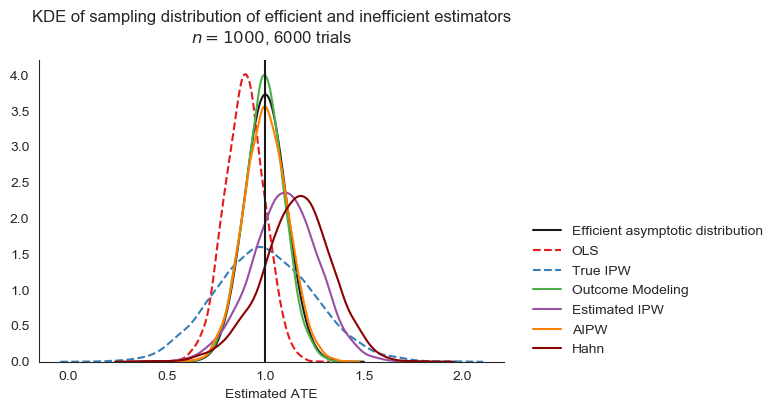

In [372]:
# Plot the KDE of most sensible estimators considered
xs = np.linspace(0.5, 1.5, 199)
plt.plot(
    xs,
    norm.pdf(xs, loc=1, scale=efficient_se),
    color="k",
    label="Efficient asymptotic distribution",
)

sns.distplot(result["ols"], label="OLS", hist=False, kde_kws=dict(ls="--"))
sns.distplot(result["true_ipw"], label="True IPW", hist=False, kde_kws=dict(ls="--"))
sns.distplot(result["outcome_modeling"], label="Outcome Modeling", hist=False)
sns.distplot(result["estimated_ipw"], label="Estimated IPW", hist=False)
sns.distplot(result["doubly_robust"], label="AIPW", hist=False)
sns.distplot(result["hahn"], label="Hahn", hist=False, kde_kws=dict(color="darkred"))

plt.axvline(1, color="k", ls="-")

sns.despine()

plt.legend(loc=(1.05, 0), frameon=False)
plt.xlabel("Estimated ATE")
plt.title(
    f"KDE of sampling distribution of efficient and inefficient estimators\n$n={n}$, {ns} trials", y=1.03
)

plt.savefig("estimators.eps", transparent=True, bbox_inches="tight")

## A harder experiment

We now let $X$ be pretty high-dimensional (an MNIST image)

In [199]:
from torch import nn
import torch
from sklearn.datasets import fetch_openml

In [294]:
# Load MNIST data and preprocess
imgs, digits = fetch_openml("mnist_784", version=1, return_X_y=True)
middle = pd.Series(digits.astype(int)).isin([4, 5, 6]).values
imgs, digits = imgs[middle].copy() / 255, digits[middle].astype(int).copy()
n = len(imgs)

In [295]:
# Define true e(x) as true_digit/10 + density_of_image
pscore = digits / 10 + imgs.mean(1)

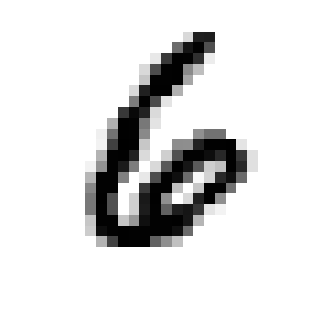

In [405]:
# Example image
plt.imshow(imgs[4, :].reshape(28,28), cmap="binary")
plt.axis('off')
plt.savefig("sixmnist.eps", dpi=20, transparent=True)

In [307]:
def convert_to_tensor(lst):
    """Convert a list of numpy arrays to torch tensors"""
    return [
        torch.as_tensor(x).float() if len(x.shape) == 2 else torch.as_tensor(x)[:, None].float()
        for x in lst
    ]

def net_initializer():
    """Initialize a couple neural networks for nuisance estimation"""
    mu1_net = nn.Sequential(
        nn.Linear(784, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 1)
    )

    mu0_net = nn.Sequential(
        nn.Linear(784, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 1)
    )

    pscore_net = nn.Sequential(
        nn.Linear(784, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 1),
        nn.Sigmoid(),
    )
    return mu1_net, mu0_net, pscore_net

def train(target, inp, net, loss=nn.MSELoss, epoch=80):
    """
    Barebones training boilerplate code. 
    Trains for 80 epochs without minibatching. 
    Arbitrary Adam optimizer settings
    """
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
    lossfn = loss()
    for e in range(epoch):
        optimizer.zero_grad()
        loss = lossfn(net(inp), target)
        loss.backward()
        optimizer.step()
    return loss.item()

In [308]:
def aipw_experiment():
    """
    Trains DML-AIPW for the MNIST experiment, returns the sample 
    ATE (treat as ground truth), AIPW estimate, AIPW SE, naive estimate
    """
    w = (np.random.rand(n) < pscore).astype(int)
    y1 = np.random.randn(n) + np.cos(2 * np.pi * (digits / 10 + imgs.mean(1)))
    y0 = np.random.randn(n)
    sate = (y1 - y0).mean()

    y = w * y1 + (1 - w) * y0
    naive = y[w == 1].mean() - y[w == 0].mean()

    # Split the data manually, then split again into treated vs. control 
    y_f1 = y[: (n // 2)].copy()
    x_f1 = imgs[: (n // 2), :].copy()
    w_f1 = w[: (n // 2)].copy()
    y_f1_t, x_f1_t = y_f1[w_f1 == 1].copy(), x_f1[w_f1 == 1].copy()
    y_f1_c, x_f1_c = y_f1[w_f1 == 0].copy(), x_f1[w_f1 == 0].copy()

    y_f2 = y[(n // 2) :].copy()
    x_f2 = imgs[(n // 2) :, :].copy()
    w_f2 = w[(n // 2) :].copy()
    y_f2_t, x_f2_t = y_f2[w_f2 == 1].copy(), x_f2[w_f2 == 1].copy()
    y_f2_c, x_f2_c = y_f2[w_f2 == 0].copy(), x_f2[w_f2 == 0].copy()

    # Ugh this ugly
    # Repackage everything into PyTorch
    (
        y_f1,
        x_f1,
        w_f1,
        y_f1_t,
        x_f1_t,
        y_f1_c,
        x_f1_c,
        y_f2,
        x_f2,
        w_f2,
        y_f2_t,
        x_f2_t,
        y_f2_c,
        x_f2_c,
    ) = convert_to_tensor(
        [
            y_f1,
            x_f1,
            w_f1,
            y_f1_t,
            x_f1_t,
            y_f1_c,
            x_f1_c,
            y_f2,
            x_f2,
            w_f2,
            y_f2_t,
            x_f2_t,
            y_f2_c,
            x_f2_c,
        ]
    )
    
    # Train nets on fold 1
    mu1_f1, mu0_f1, pscore_f1 = net_initializer()
    loss1_f1, loss0_f1, loss_ps_f1 = (
        train(y_f1_t, x_f1_t, mu1_f1),
        train(y_f1_c, x_f1_c, mu0_f1),
        train(w_f1, x_f1, pscore_f1),
    )
    
    # Train nets on fold 2
    mu1_f2, mu0_f2, pscore_f2 = net_initializer()
    loss1_f2, loss0_f2, loss_ps_f2 = (
        train(y_f2_t, x_f2_t, mu1_f2),
        train(y_f2_c, x_f2_c, mu0_f2),
        train(w_f2, x_f2, pscore_f2),
    )
    
    # Eval nets trained on fold 1 on fold 2, and vice versa
    # Put everything back into numpy
    aipw_2 = (
        (
            mu1_f1(x_f2)
            - mu0_f1(x_f2)
            + w_f2 * (y_f2 - mu1_f1(x_f2)) / pscore_f1(x_f2)
            - (1 - w_f2) * (y_f2 - mu0_f1(x_f2)) / (1 - pscore_f1(x_f2))
        )
        .detach()
        .numpy()
        .flatten()
        .astype(float)
    )
    aipw_1 = (
        (
            mu1_f2(x_f1)
            - mu0_f2(x_f1)
            + w_f1 * (y_f1 - mu1_f2(x_f1)) / pscore_f2(x_f1)
            - (1 - w_f1) * (y_f1 - mu0_f2(x_f1)) / (1 - pscore_f2(x_f1))
        )
        .detach()
        .numpy()
        .flatten()
        .astype(float)
    )

    # Assemble the AIPW terms
    aipw = np.r_[aipw_1, aipw_2]
    
    # Take mean and SE
    ate_estimate = aipw.mean()
    ate_se = aipw.std() / len(aipw) ** 0.5

    return sate, ate_estimate, ate_se, naive

In [309]:
result = [aipw_experiment() for _ in tqdm(range(200))]
result_df = pd.DataFrame(result, columns=["sate", "ate_est", "ate_se", "naive"])

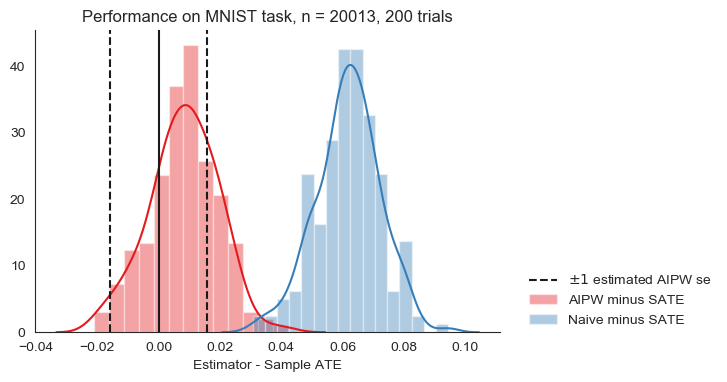

In [418]:
# Plot the performance of DML-AIPW
sns.distplot(result_df["ate_est"] - result_df["sate"], label="AIPW minus SATE")
sns.distplot(result_df["naive"] - result_df["sate"], label="Naive minus SATE")
plt.xlabel("Estimator - Sample ATE")
plt.axvline(0, color="k")
plt.axvline(result_df["ate_se"].mean(), color="k", ls="--")
plt.axvline(-result_df["ate_se"].mean(), color="k", ls="--", label="$\pm 1$ estimated AIPW se")

sns.despine()
plt.legend(loc=(1.05,0), frameon=False)

plt.title(f"Performance on MNIST task, n = {n}, {200} trials")
plt.savefig("mnist.pdf", bbox_inches="tight", transparent=True)